#### Goal
 
Using the cleaned and preprocessed version of the Titanic dataset:
1.	Build and evaluate the set of nine classifiers to predict whether the passengers survived the sinking of the Titanic.
    - Models: logistic regression, support vector machines, k-nearest neighbors, naive Bayes and artificial neural network with two hidden layers
2.	Compare the performance of all the nine classifiers using ROC-AUC as well as confusion-matrix based performance evaluation measures. Select the “best performer” on the hold-out testset.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import warnings

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from IPython.display import Markdown, Image

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
%%html 
<style>
table {float:left; border-style: solid;}
</style>

Utils

In [3]:
def get_cm_based_measures(conf_matrix):
    TN = conf_matrix[0][0]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]
    FP = conf_matrix[0][1]
    
    # TPR = TP / TP + FN
    TPR = round(TP / (TP + FN), 6)
    # TNR = TN / TN + FP
    TNR = round(TN / (TN + FP), 6)
    # FPR = FP / TN + FP
    FPR = round(FP / (TN + FP), 6)
    # FNR = FN / TP + FN
    FNR = round(FN / (TP + FN), 6)
    # accuracy (TP + TN) / (TP + TN + FP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    # precision = TP / TP + FP
    precision = TP / (TP + FP)
    # recall = TP / TP + FN
    recall_pos = round(TP / (TP + FN), 6)
    recall_neg = round(TN / (TN + FP), 6)
    # avg class accuracy
    avg_acc = 1/2*(recall_pos+recall_neg)
    
    print( f'TPR: {TPR}   TNR: {TNR}   FPR: {FPR}   FNR: {FNR}   Accuracy: {accuracy}   Avg. Class Acc: {avg_acc}')

### Dataset

In [4]:
# importing the dataset
data_path = 'data/'
file_name = 'titanic_preproc_df.csv'
titanic_df = pd.read_csv(data_path+file_name)
display(titanic_df.shape)
titanic_df.info()
titanic_df.head()

(891, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Survived    891 non-null    int64
 1   Pclass      891 non-null    int64
 2   Salutation  891 non-null    int64
 3   FareBand    891 non-null    int64
 4   AgeBand     891 non-null    int64
 5   FSizeBand   891 non-null    int64
dtypes: int64(6)
memory usage: 41.9 KB


,Survived,Pclass,Salutation,FareBand,AgeBand,FSizeBand
0,0,3,0,1,2,2
1,1,1,3,4,4,2
2,1,3,4,2,2,1
3,1,1,3,4,3,2
4,0,3,0,2,3,1


___
### Models

#### Models with default parameters

**1. Decision Trees**

#### Training

CPU times: user 1.76 ms, sys: 334 µs, total: 2.09 ms
Wall time: 1.86 ms


#### Execution Time - Classification

CPU times: user 906 µs, sys: 123 µs, total: 1.03 ms
Wall time: 985 µs


#### Model in Test Data

Accuracy: 0.8095
Average class accuracy: 0.7823
TPR: 0.652482   TNR: 0.912037   FPR: 0.087963   FNR: 0.347518   Accuracy: 0.8095238095238095   Avg. Class Acc: 0.7822595


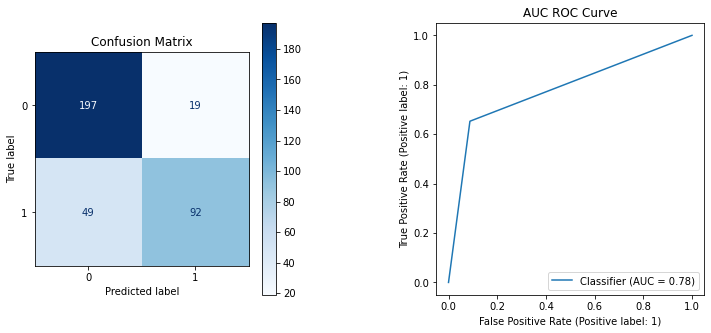

#### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       216
           1       0.83      0.65      0.73       141

    accuracy                           0.81       357
   macro avg       0.81      0.78      0.79       357
weighted avg       0.81      0.81      0.80       357



In [5]:
# split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
dtc = DecisionTreeClassifier() # criterion=gini by default
%time dtc.fit(X_train, y_train)

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = dtc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

# average class accuracy score
avg_acc_test = metrics.balanced_accuracy_score(y_test, predicted_Y_test)
print('Average class accuracy:', '{:.4f}'.format(avg_acc_test))

# confusion matrix-based performance measures
label_class_set = dtc.classes_
CM = metrics.confusion_matrix(y_test, predicted_Y_test, labels=label_class_set)
get_cm_based_measures(CM)

# plotting results -----------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'wspace': 0.5})

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# calculate and plot ROC AUC curve
roc_disp = metrics.RocCurveDisplay.from_predictions(y_test, predicted_Y_test, ax=ax[1])
ax[1].set_title("AUC ROC Curve")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

**2. Random Forest**

#### Training

CPU times: user 74.1 ms, sys: 1.48 ms, total: 75.6 ms
Wall time: 75.4 ms


#### Execution Time - Classification

CPU times: user 9.18 ms, sys: 469 µs, total: 9.65 ms
Wall time: 9.57 ms


#### Model in Test Data

Accuracy: 0.8179
Average class accuracy: 0.7966
TPR: 0.695035   TNR: 0.898148   FPR: 0.101852   FNR: 0.304965   Accuracy: 0.8179271708683473   Avg. Class Acc: 0.7965914999999999


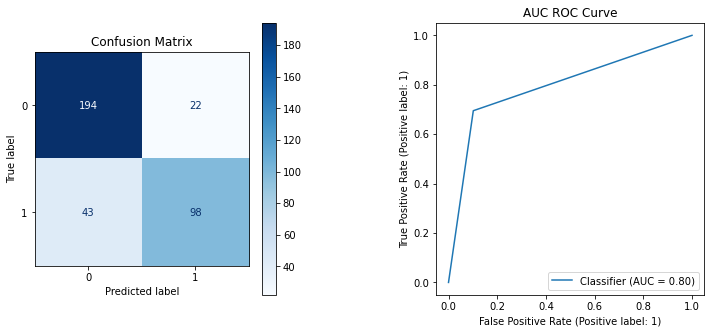

#### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       216
           1       0.82      0.70      0.75       141

    accuracy                           0.82       357
   macro avg       0.82      0.80      0.80       357
weighted avg       0.82      0.82      0.81       357



In [6]:
# split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
rfc =  RandomForestClassifier() # criterion=gini by default
%time rfc.fit(X_train, y_train)

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = rfc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

# average class accuracy score
avg_acc_test = metrics.balanced_accuracy_score(y_test, predicted_Y_test)
print('Average class accuracy:', '{:.4f}'.format(avg_acc_test))

# confusion matrix-based performance measures
CM = metrics.confusion_matrix(y_test, predicted_Y_test, labels=label_class_set)
get_cm_based_measures(CM)

# plotting results -----------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'wspace': 0.5})
label_class_set = rfc.classes_

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# calculate and plot ROC AUC curve
roc_disp = metrics.RocCurveDisplay.from_predictions(y_test, predicted_Y_test, ax=ax[1])
ax[1].set_title("AUC ROC Curve")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

**3. AdaBoost**

#### Training

CPU times: user 40.1 ms, sys: 1.1 ms, total: 41.2 ms
Wall time: 40.9 ms


#### Execution Time - Classification

CPU times: user 5.98 ms, sys: 545 µs, total: 6.52 ms
Wall time: 6.36 ms


#### Model in Test Data

Accuracy: 0.8263
Average class accuracy: 0.8085
TPR: 0.723404   TNR: 0.893519   FPR: 0.106481   FNR: 0.276596   Accuracy: 0.8263305322128851   Avg. Class Acc: 0.8084614999999999


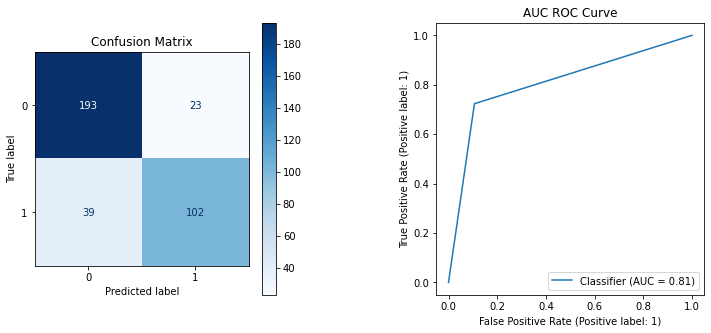

#### Classification Report

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       216
           1       0.82      0.72      0.77       141

    accuracy                           0.83       357
   macro avg       0.82      0.81      0.81       357
weighted avg       0.83      0.83      0.82       357



In [7]:
# split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
abc =  AdaBoostClassifier() # the estimator is DecisionTreeClassifier initialized with max_depth=1 by default
%time abc.fit(X_train, y_train)

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = abc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

# average class accuracy score
avg_acc_test = metrics.balanced_accuracy_score(y_test, predicted_Y_test)
print('Average class accuracy:', '{:.4f}'.format(avg_acc_test))

# confusion matrix-based performance measures
CM = metrics.confusion_matrix(y_test, predicted_Y_test, labels=label_class_set)
get_cm_based_measures(CM)

# plotting results -----------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'wspace': 0.5})
label_class_set = abc.classes_

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# calculate and plot ROC AUC curve
roc_disp = metrics.RocCurveDisplay.from_predictions(y_test, predicted_Y_test, ax=ax[1])
ax[1].set_title("AUC ROC Curve")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

**4. Gradient Boosting**

#### Training

CPU times: user 40.9 ms, sys: 836 µs, total: 41.8 ms
Wall time: 41.8 ms


#### Execution Time - Classification

CPU times: user 1.42 ms, sys: 83 µs, total: 1.5 ms
Wall time: 1.45 ms


#### Model in Test Data

Accuracy: 0.8235
Average class accuracy: 0.7975
TPR: 0.673759   TNR: 0.921296   FPR: 0.078704   FNR: 0.326241   Accuracy: 0.8235294117647058   Avg. Class Acc: 0.7975275


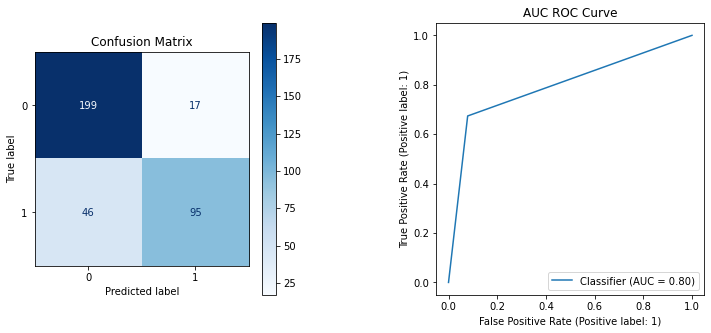

#### Classification Report

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       216
           1       0.85      0.67      0.75       141

    accuracy                           0.82       357
   macro avg       0.83      0.80      0.81       357
weighted avg       0.83      0.82      0.82       357



In [8]:
# split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
gbc =  GradientBoostingClassifier() # criterion=friedman_mse by default
%time gbc.fit(X_train, y_train)

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = gbc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

# average class accuracy score
avg_acc_test = metrics.balanced_accuracy_score(y_test, predicted_Y_test)
print('Average class accuracy:', '{:.4f}'.format(avg_acc_test))

# confusion matrix-based performance measures
label_class_set = gbc.classes_
CM = metrics.confusion_matrix(y_test, predicted_Y_test, labels=label_class_set)
get_cm_based_measures(CM)

# plotting results -----------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'wspace': 0.5})

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# calculate and plot ROC AUC curve
roc_disp = metrics.RocCurveDisplay.from_predictions(y_test, predicted_Y_test, ax=ax[1])
ax[1].set_title("AUC ROC Curve")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

**5. Logistic Regression**

#### Execution Time - Training

CPU times: user 14.7 ms, sys: 5.84 ms, total: 20.6 ms
Wall time: 5.79 ms


#### Execution Time - Classification

CPU times: user 350 µs, sys: 99 µs, total: 449 µs
Wall time: 157 µs


#### Model in Test Data

Simple accuracy: 0.7787
Average class accuracy: 0.7580
TPR: 0.659574   TNR: 0.856481   FPR: 0.143519   FNR: 0.340426   Accuracy: 0.7787114845938375   Avg. Class Acc: 0.7580275000000001


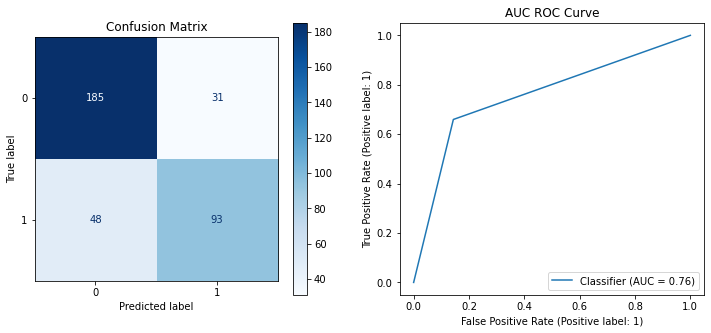

#### Classification Report

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       216
           1       0.75      0.66      0.70       141

    accuracy                           0.78       357
   macro avg       0.77      0.76      0.76       357
weighted avg       0.78      0.78      0.78       357



In [9]:
# preprocess dataset, split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# model: logistic regression
lg = LogisticRegression()

# training 
display(Markdown("#### Execution Time - Training"))
%time lg.fit(X_train, y_train) # timing training process

# predictions of label classes for the unseen test data ----------------------------------
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = lg.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# metrics
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Simple accuracy:', '{:.4f}'.format(accuracy_test))

# average class accuracy score
avg_acc_test = metrics.balanced_accuracy_score(y_test, predicted_Y_test)
print('Average class accuracy:', '{:.4f}'.format(avg_acc_test))

# confusion matrix-based performance measures
label_class_set = gbc.classes_
CM = metrics.confusion_matrix(y_test, predicted_Y_test, labels=label_class_set)
get_cm_based_measures(CM)

# plotting results -----------------------------------------------------------------------
label_class_set = lg.classes_
fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'hspace': 0.3})

# calculate and plot confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# calculate and plot ROC AUC curve
roc_disp = metrics.RocCurveDisplay.from_predictions(y_test, predicted_Y_test, ax=ax[1])
ax[1].set_title("AUC ROC Curve")

plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

**6. SVM**

#### Execution Time - Training

CPU times: user 9.01 ms, sys: 392 µs, total: 9.4 ms
Wall time: 9.14 ms


#### Execution Time - Classification

CPU times: user 8.75 ms, sys: 267 µs, total: 9.02 ms
Wall time: 8.34 ms


#### Model in Test Data

Accuracy: 0.8095
Average class accuracy: 0.7921
TPR: 0.70922   TNR: 0.875   FPR: 0.125   FNR: 0.29078   Accuracy: 0.8095238095238095   Avg. Class Acc: 0.79211


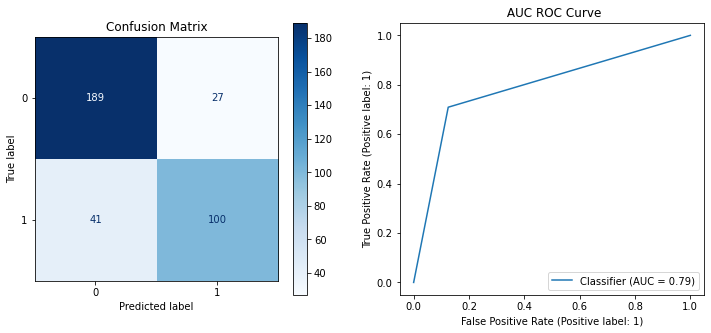

#### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       216
           1       0.79      0.71      0.75       141

    accuracy                           0.81       357
   macro avg       0.80      0.79      0.80       357
weighted avg       0.81      0.81      0.81       357



In [10]:
# preprocess dataset, split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# model: SVC with default parameters
svc_ln = SVC()

# training 
display(Markdown("#### Execution Time - Training"))
%time svc_ln.fit(X_train, y_train) # timing training

# predictions of label classes for the unseen test data -----------------------------------
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = svc_ln.predict(X_test)

display(Markdown("#### Model in Test Data"))
# metrics
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

# average class accuracy score
avg_acc_test = metrics.balanced_accuracy_score(y_test, predicted_Y_test)
print('Average class accuracy:', '{:.4f}'.format(avg_acc_test))

# confusion matrix-based performance measures
label_class_set = svc_ln.classes_
CM = metrics.confusion_matrix(y_test, predicted_Y_test, labels=label_class_set)
get_cm_based_measures(CM)

# plotting results -----------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'hspace': 0.3})

# plot confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay(CM).plot(cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# calculate and plot ROC AUC curve
roc_disp = metrics.RocCurveDisplay.from_predictions(y_test, predicted_Y_test, ax=ax[1])
ax[1].set_title(" AUC ROC Curve")

plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

**7. k-nearest neighbors**

#### Execution Time - Training

CPU times: user 572 µs, sys: 140 µs, total: 712 µs
Wall time: 694 µs


#### Execution Time - Classification

CPU times: user 8.42 ms, sys: 1.09 ms, total: 9.51 ms
Wall time: 8.47 ms


#### Model in Test Data

Accuracy: 0.7927
Average class accuracy: 0.7721
TPR: 0.673759   TNR: 0.87037   FPR: 0.12963   FNR: 0.326241   Accuracy: 0.7927170868347339   Avg. Class Acc: 0.7720644999999999


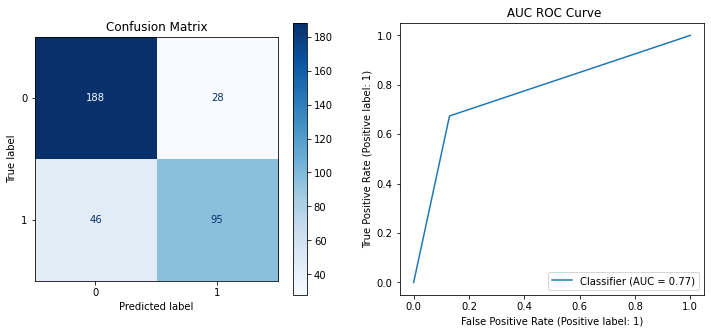

#### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.87      0.84       216
           1       0.77      0.67      0.72       141

    accuracy                           0.79       357
   macro avg       0.79      0.77      0.78       357
weighted avg       0.79      0.79      0.79       357



In [11]:
# preprocess dataset, split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# model: k-neighbors
neigh = KNeighborsClassifier()

# training 
display(Markdown("#### Execution Time - Training"))
%time neigh.fit(X_train, y_train) # timing training

# predictions of label classes for the unseen test data -----------------------------------
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = neigh.predict(X_test)

display(Markdown("#### Model in Test Data"))
# metrics
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

# average class accuracy score
avg_acc_test = metrics.balanced_accuracy_score(y_test, predicted_Y_test)
print('Average class accuracy:', '{:.4f}'.format(avg_acc_test))

# confusion matrix-based performance measures
label_class_set = neigh.classes_
CM = metrics.confusion_matrix(y_test, predicted_Y_test, labels=label_class_set)
get_cm_based_measures(CM)

# plotting results -----------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'hspace': 0.3})

# plot confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay(CM).plot(cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# calculate and plot ROC AUC curve
roc_disp = metrics.RocCurveDisplay.from_predictions(y_test, predicted_Y_test, ax=ax[1])
ax[1].set_title(" AUC ROC Curve")

plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

**8. Naive Bayes**

#### Execution Time - Training

CPU times: user 2.49 ms, sys: 812 µs, total: 3.3 ms
Wall time: 2.97 ms


#### Execution Time - Classification

CPU times: user 992 µs, sys: 165 µs, total: 1.16 ms
Wall time: 1.1 ms


#### Model in Test Data

Accuracy: 0.7759
Average class accuracy: 0.7631
TPR: 0.702128   TNR: 0.824074   FPR: 0.175926   FNR: 0.297872   Accuracy: 0.7759103641456583   Avg. Class Acc: 0.763101


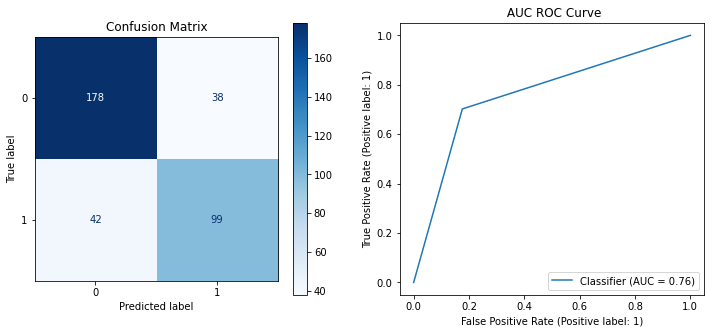

#### Classification Report

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       216
           1       0.72      0.70      0.71       141

    accuracy                           0.78       357
   macro avg       0.77      0.76      0.76       357
weighted avg       0.77      0.78      0.78       357



In [12]:
# preprocess dataset, split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# model: k-neighbors
cnb = CategoricalNB()

# training 
display(Markdown("#### Execution Time - Training"))
%time cnb.fit(X_train, y_train) # timing training

# predictions of label classes for the unseen test data -----------------------------------
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = cnb.predict(X_test)

display(Markdown("#### Model in Test Data"))
# metrics
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

# average class accuracy score
avg_acc_test = metrics.balanced_accuracy_score(y_test, predicted_Y_test)
print('Average class accuracy:', '{:.4f}'.format(avg_acc_test))

# confusion matrix-based performance measures
label_class_set = cnb.classes_
CM = metrics.confusion_matrix(y_test, predicted_Y_test, labels=label_class_set)
get_cm_based_measures(CM)

# plotting results -----------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'hspace': 0.3})

# plot confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay(CM).plot(cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# calculate and plot ROC AUC curve
roc_disp = metrics.RocCurveDisplay.from_predictions(y_test, predicted_Y_test, ax=ax[1])
ax[1].set_title(" AUC ROC Curve")

plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

**9. Artificial neural network with two hidden layers**

#### Execution Time - Training

CPU times: user 4.22 s, sys: 1.1 s, total: 5.32 s
Wall time: 1.27 s


#### Execution Time - Classification

CPU times: user 6.97 ms, sys: 1.98 ms, total: 8.95 ms
Wall time: 2.84 ms


#### Model in Test Data

Accuracy: 0.8011
Average class accuracy: 0.7753
TPR: 0.652482   TNR: 0.898148   FPR: 0.101852   FNR: 0.347518   Accuracy: 0.8011204481792717   Avg. Class Acc: 0.775315


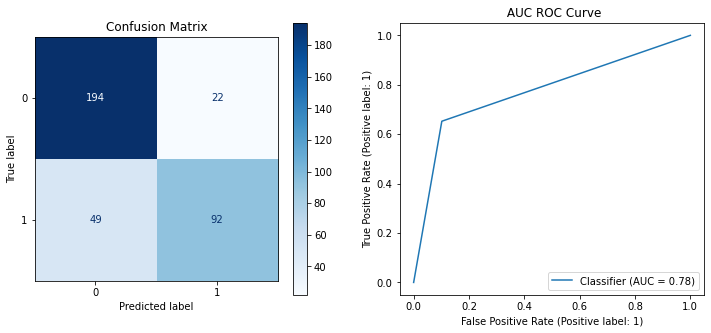

#### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       216
           1       0.81      0.65      0.72       141

    accuracy                           0.80       357
   macro avg       0.80      0.78      0.78       357
weighted avg       0.80      0.80      0.80       357



In [13]:
# preprocess dataset, split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# model: k-neighbors
mlp = MLPClassifier(hidden_layer_sizes=(100,100)) # 2 layers and the remaining default params

# training 
display(Markdown("#### Execution Time - Training"))
%time mlp.fit(X_train, y_train) # timing training

# predictions of label classes for the unseen test data -----------------------------------
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = mlp.predict(X_test)

display(Markdown("#### Model in Test Data"))
# metrics
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

# average class accuracy score
avg_acc_test = metrics.balanced_accuracy_score(y_test, predicted_Y_test)
print('Average class accuracy:', '{:.4f}'.format(avg_acc_test))

# confusion matrix-based performance measures
label_class_set = mlp.classes_
CM = metrics.confusion_matrix(y_test, predicted_Y_test, labels=label_class_set)
get_cm_based_measures(CM)

# plotting results -----------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'hspace': 0.3})

# plot confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay(CM).plot(cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# calculate and plot ROC AUC curve
roc_disp = metrics.RocCurveDisplay.from_predictions(y_test, predicted_Y_test, ax=ax[1])
ax[1].set_title(" AUC ROC Curve")

plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

### Models Comparison

**Performance summary**:

| Model                      | ROC index                           | Accuracy                                | Avg. class accuracy                     | TPR                                       | FPR                                       | TNR                                       | FNR                                |
|----------------------------|-------------------------------------|-----------------------------------------|-----------------------------------------|-------------------------------------------|-------------------------------------------|-------------------------------------------|------------------------------------|
| Decision Trees             |                                  78 |                                  80.95% |                                  78.23% | 0.652482                                  | 0.087963                                  | 0.912037                                  | 0.347518                           |
| Random Forest              |                                  80 |                                  81.79% |                                  79.66% | 0.695035                                  | 0.101852                                  | 0.898148                                  | 0.304965                           |
| AdaBoost                   | <span style="color:green">81</span> | <span style="color:green">82.63%</span> | <span style="color:green">80.85%</span> | <span style="color:green">0.723404</span> |                                  0.106481 |                                  0.893519 | <span style="color:green">0.276596 |
| Gradient Boosting          |                                  80 |                                  82.35% |                                  79.75% | 0.673759                                  | <span style="color:green">0.078704</span> | <span style="color:green">0.921296</span> |                           0.326241 |
| Logistic regression        |                                  76 |                                  77.87% |                                  75.80% | 0.659574                                  |                                  0.143519 |                                  0.856481 |                           0.340426 |
| SVM                        |                                  79 |                                  80.95% |                                  79.21% | 0.70922                                   |                                     0.125 |                                     0.875 |                            0.29078 |
| KNN                        |                                  77 |                                  79.27% |                                  77.21% | 0.673759                                  |                                   0.12963 |                                   0.87037 |                           0.326241 |
| Naive Bayes                |                                  76 |                                  77.59% |                                  76.31% | 0.702128                                  |                                  0.175926 |                                  0.824074 |                           0.297872 |
| ANN with two hidden layers |                                  78 |                                  80.11% |                                  77.53% | 0.652482                                  | 0.101852                                  | 0.898148                                  | 0.34751                            |
|                            |                                     |                                         |                                         |                                           |                                           |                                           |                                    |
| **Best Values**            |                              **81** | **82.63%**                             | **80.85%**                             |                              **0.723404** |                                **0.078704** |                              **0.921296** |                       **0.276596** |

In the table above the best scores are highlighted in green, i.e., the highest values are highlighted for all the columns except FPR and FNR where the minimum are the ones highlighted (since lower values represent best performance).

In terms of accuracy, SVM and the tree-based models resulted in higher values. The ROC index was better for Random Forest, AdaBoost, and Gradient Boosting. Similarly, AdaBoost had the highest TPR and the lowest FNR, while Gradient Boosting had the highest TNR and lowest FPR. Overall, Logistic Regression, Naive Bayes, and KNN had poorer performance based on the evaluation measures analyzed.

Based on the results from the table, I think the best performer for this dataset was AdaBoost.